In [1]:
# reloads all sourced file before running called functions; avoids having to restart kernel for every modification
%load_ext autoreload
%autoreload 2

# autocompletion
%config Completer.use_jedi = False

In [2]:
PATH = ''
DATA_PATH = ''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import os
import pickle
import sys
sys.path.append('../')

from torch_nn import NeuralNetwork, NetworkLearner
from miscellanea import plot_binned
from gmm_utils import plot_1D_cutoffs, plot_1D_statistics_cutoffs
from muons_utils import MuonFeatures, TempQRSimulator, plot_waldo_predictions, unfold_data
from qr_algorithms.complete_list import classifier_cde_dict
from qr_utils.qr_functions import train_qr_algo
from lumin.nn.data.fold_yielder import FoldYielder

In [4]:
confidence_level = 0.683
restricted = False

## Simulator

In [14]:
if restricted:
    simulator = MuonFeatures(param_grid_bounds=(50, 5000), 
                             param_grid_size=10_000, 
                             simulated_data=None, observed_data=None,
                             observed_d=None, param_d=1, 
                             param_column=None)
else:
    simulator = MuonFeatures(param_grid_bounds=(50, 8000), 
                         param_grid_size=10_000, 
                         simulated_data=None, observed_data=None,
                         observed_d=None, param_d=1, 
                         param_column=None)

# Critical Values

In [6]:
cutoffs_data = FoldYielder(foldfile='./data/training_cutoffs.hdf5')
cutoffs_data.foldfile.keys()

<KeysViewHDF5 ['fold_1', 'fold_10', 'fold_11', 'fold_12', 'fold_13', 'fold_14', 'fold_15', 'fold_16', 'fold_17', 'meta_data']>

In [7]:
simulator.b_prime_sample_theta = unfold_data(fy=cutoffs_data, name='targets', exclude_name='None')

qr_conditional_means = unfold_data(fy=cutoffs_data, name='quantreg_cond_mean', exclude_name='None')
qr_conditional_vars = unfold_data(fy=cutoffs_data, name='quantreg_cond_var', exclude_name='None')
#qr_conditional_vars[qr_conditional_vars <= 1e-6] = 1e-6

qr_conditional_means.shape, qr_conditional_vars.shape, simulator.b_prime_sample_theta.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2931.44it/s]


((221679,), (221679,), (221679,))

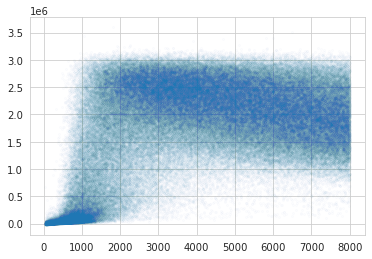

In [8]:
plt.scatter(x=simulator.b_prime_sample_theta, y=qr_conditional_vars, s=5, alpha=0.01)
plt.show()

#### VAR

In [9]:
qr_statistics = ((qr_conditional_means.reshape(-1,1) - simulator.b_prime_sample_theta.reshape(-1,1))**2)/qr_conditional_vars.reshape(-1,1)
qr_statistics.shape

(221679, 1)

In [122]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB, predicted_cutoffs_xgb = train_qr_algo(model_obj=simulator, alpha=confidence_level,
                                              theta_mat=simulator.b_prime_sample_theta, stats_mat=qr_statistics,
                                              algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                              prediction_grid=simulator.param_grid)

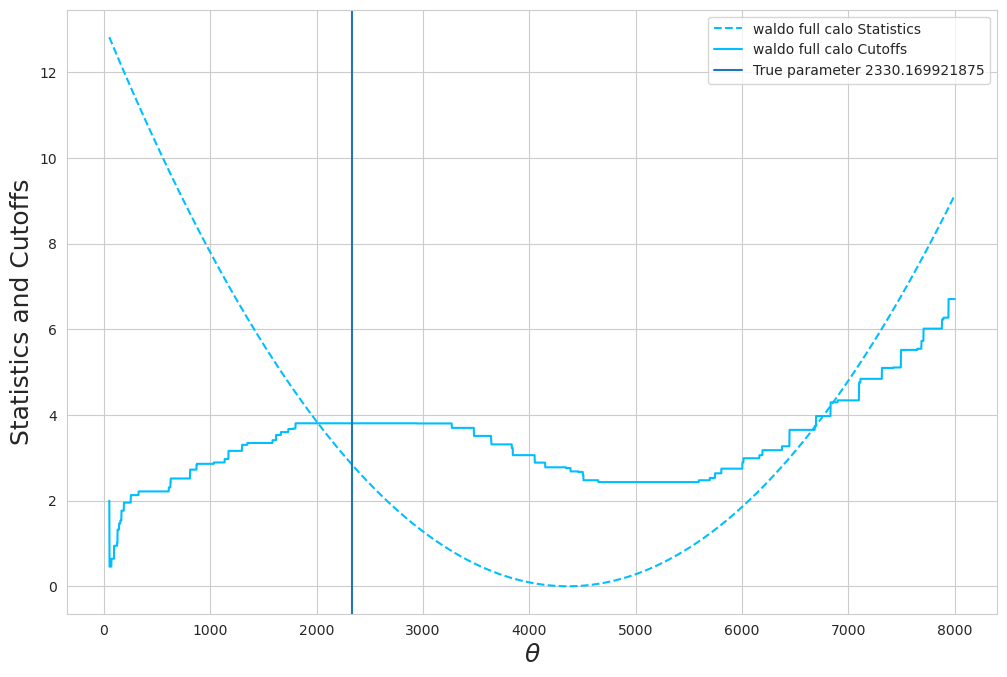

In [123]:
#plot_1D_cutoffs(parameters=simulator.param_grid, predicted_cutoffs={'waldo full calo cutoffs': predicted_cutoffs_xgb})
idx_obs = 100

plot_1D_statistics_cutoffs(parameters=simulator.param_grid, 
                           stats_cutoffs={'waldo full calo': (observed_statistics[idx_obs, :], predicted_cutoffs_xgb)}, 
                           true_param=observed_theta[idx_obs],
                           figsize=(12, 8), dpi=300, scale='linear', save_path=None)

#### NOVAR

In [11]:
qr_statistics_novar = (qr_conditional_means.reshape(-1,1) - simulator.b_prime_sample_theta.reshape(-1,1))**2
qr_statistics_novar.shape

(221679, 1)

In [124]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB_novar, predicted_cutoffs_xgb_novar = train_qr_algo(model_obj=simulator, alpha=confidence_level,
                                                          theta_mat=simulator.b_prime_sample_theta, stats_mat=qr_statistics_novar,
                                                          algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                                          prediction_grid=simulator.param_grid)

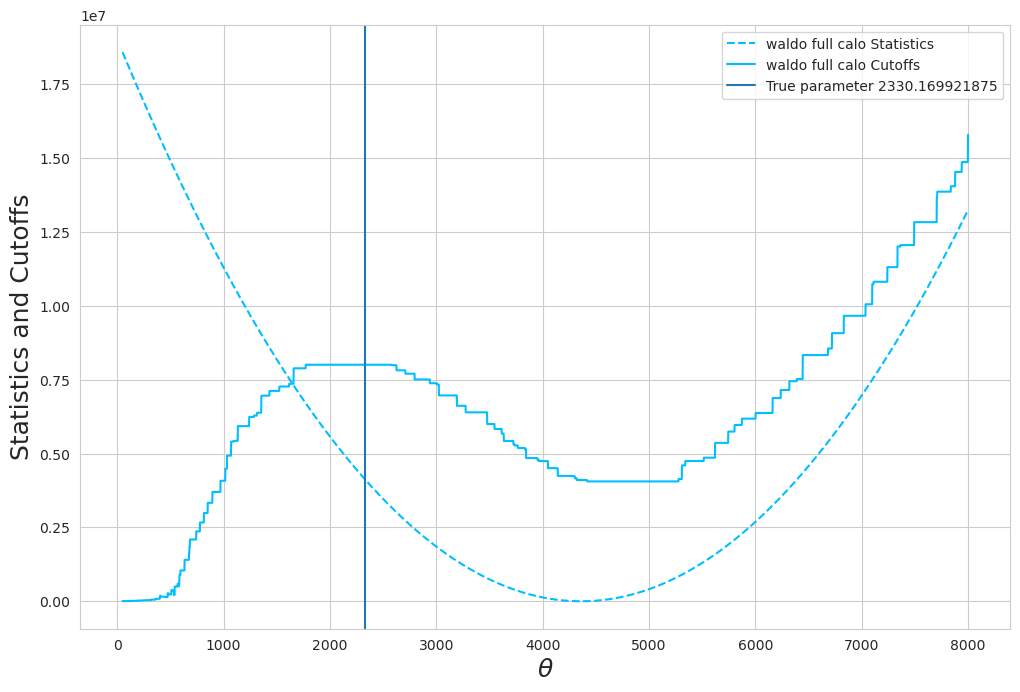

In [125]:
# plot_1D_cutoffs(parameters=simulator.param_grid, predicted_cutoffs={'28 feats full waldo-NOVAR': predicted_cutoffs_xgb_novar})
idx_obs = 100

plot_1D_statistics_cutoffs(parameters=simulator.param_grid, 
                           stats_cutoffs={'waldo full calo': (observed_statistics_novar[idx_obs, :], predicted_cutoffs_xgb_novar)}, 
                           true_param=observed_theta[idx_obs],
                           figsize=(12, 8), dpi=300, scale='linear', save_path=None)

# Confidence Sets

In [7]:
observations = FoldYielder(foldfile='./data/validation.hdf5')
observations.foldfile.keys()

<KeysViewHDF5 ['fold_0', 'meta_data']>

In [8]:
observed_theta = unfold_data(fy=observations, name='targets', exclude_name='None')

obs_conditional_means = unfold_data(fy=observations, name='val_cond_mean', exclude_name='None')
obs_conditional_vars = unfold_data(fy=observations, name='val_cond_var', exclude_name='None')
# obs_conditional_vars[obs_conditional_vars < 0] = 1e-6

if restricted:
    obs_conditional_means = obs_conditional_means[observed_theta <= 5000]
    obs_conditional_vars = obs_conditional_vars[observed_theta <= 5000]
    observed_theta = observed_theta[observed_theta <= 5000]

obs_conditional_means.shape, obs_conditional_vars.shape, observed_theta.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 3111.50it/s]


((24631,), (24631,), (24631,))

In [74]:
tile_param_grid = np.tile(simulator.param_grid, observed_theta.shape[0]).reshape(observed_theta.shape[0], simulator.param_grid_size)

#### VAR

In [154]:
observed_statistics = (np.subtract(obs_conditional_means.reshape(-1,1), tile_param_grid)**2)/obs_conditional_vars.reshape(-1, 1)

In [155]:
which_param = observed_statistics <= predicted_cutoffs_xgb.reshape(1, -1)
which_param.shape

(24631, 10000)

In [156]:
var_confidence_sets = [simulator.param_grid[which_param[i, :]] for i in range(observed_theta.shape[0])]
len(var_confidence_sets)

24631

#### NOVAR

In [157]:
observed_statistics_novar = np.subtract(obs_conditional_means.reshape(-1,1), tile_param_grid)**2

In [158]:
which_param_novar = observed_statistics_novar <= predicted_cutoffs_xgb_novar.reshape(1, -1)
which_param_novar.shape

(24631, 10000)

In [159]:
novar_confidence_sets = [simulator.param_grid[which_param_novar[i, :]] for i in range(observed_theta.shape[0])]
len(novar_confidence_sets)

24631

#### PREDICTION

In [10]:
if confidence_level == 0.683:
    c = 1
elif confidence_level == 0.9:
    c = 1.645
elif confidence_level == 0.95:
    c = 1.96
else:
    raise ValueError

obs_conditional_vars[obs_conditional_vars < 0] = 1e-6
prediction_sets = np.hstack((
    np.clip((obs_conditional_means-c*np.sqrt(obs_conditional_vars)), a_min=50, a_max=8000).reshape(-1, 1), 
    np.clip((obs_conditional_means+c*np.sqrt(obs_conditional_vars)), a_min=50, a_max=8000).reshape(-1, 1)
))
prediction_sets.shape

(24631, 2)

#### PLOT

##### Coverage Diagnostics

In [160]:
var_diagnostics_stats = ((np.subtract(obs_conditional_means.reshape(-1,1), observed_theta.reshape(-1, 1))**2)/obs_conditional_vars.reshape(-1, 1)).reshape(-1, )
novar_diagnostics_stats = (np.subtract(obs_conditional_means.reshape(-1,1), observed_theta.reshape(-1, 1))**2).reshape(-1, )
var_diagnostics_stats.shape, novar_diagnostics_stats.shape

((24631,), (24631,))

In [161]:
var_diagnostics_cutoffs = qr_XGB.predict(X=observed_theta.reshape(-1, 1))
novar_diagnostics_cutoffs = qr_XGB_novar.predict(X=observed_theta.reshape(-1, 1))
var_diagnostics_cutoffs.shape, novar_diagnostics_cutoffs.shape

((24631,), (24631,))

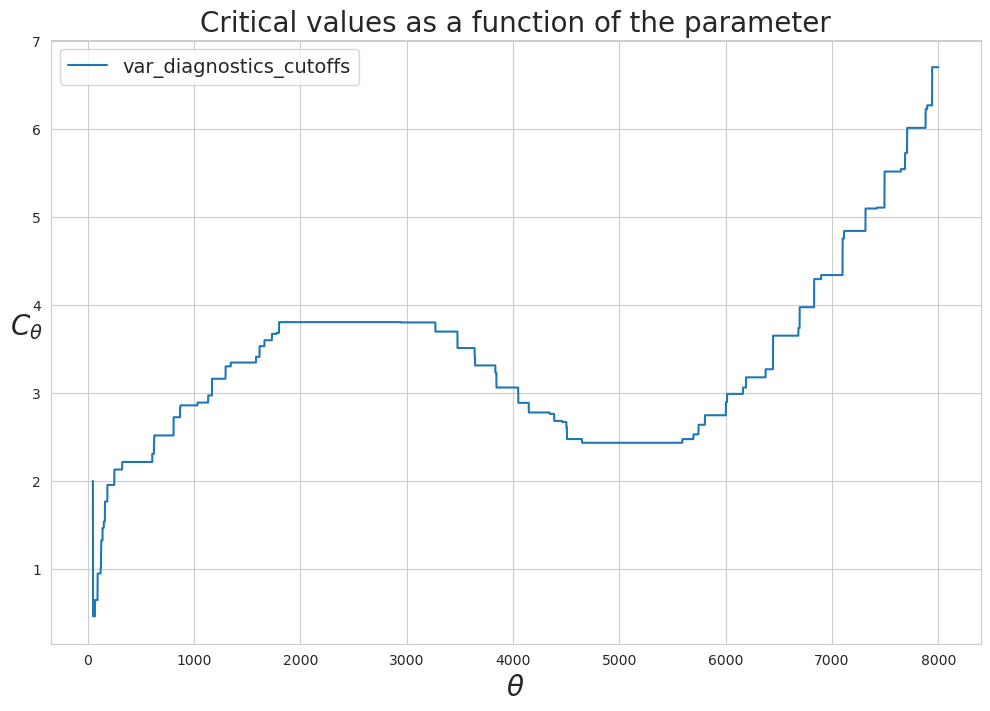

In [162]:
plot_1D_cutoffs(parameters=observed_theta, predicted_cutoffs={'var_diagnostics_cutoffs': var_diagnostics_cutoffs})#, 'novar_diagnostics_cutoffs': novar_diagnostics_cutoffs})

In [12]:
prediction_indicators = np.array([1 if (observed_theta[i] >= np.min(prediction_sets[i])) & (observed_theta[i] <= np.max(prediction_sets[i])) else 0 for i in range(len(observed_theta))])
prediction_indicators.mean()

0.6753278389021964

##### Plot

In [168]:
plot_binned(true_params=observed_theta, 
            confidence_sets={'Waldo': var_confidence_sets, 'Waldo - NOVAR': novar_confidence_sets},
            prediction_sets={'Prediction sets': prediction_sets},
            coverage_diagnostics={'Waldo': {'statistics': var_diagnostics_stats, 'cutoffs': var_diagnostics_cutoffs}, 
                                  'Waldo - NOVAR': {'statistics': novar_diagnostics_stats, 'cutoffs': novar_diagnostics_cutoffs},
                                  'Prediction sets': {'indicators': prediction_indicators}},
            n_bins=19, start=np.min(simulator.param_grid), end=np.max(simulator.param_grid), confidence_level=confidence_level, 
            plot_length_quantiles=True, plot_coverage_bins=False,
            save_fig_path=None, # os.path.join(PATH, f'waldo/results/muons/full_calo/waldo_varLinear_novar_allMSEnoWeight.png'),
            is_azure=is_azure)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.55it/s]


fitting GAM
fitting GAM
fitting GAM


##### Save results

In [45]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_var_results.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': var_confidence_sets,
                 'statistics_diag': var_diagnostics_stats, 'cutoffs_diag': var_diagnostics_cutoffs}, f)

In [60]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_novar_results.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': novar_confidence_sets,
                 'statistics_diag': novar_diagnostics_stats, 'cutoffs_diag': novar_diagnostics_cutoffs}, f)

In [111]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_var_results_restricted.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': var_confidence_sets,
                 'statistics_diag': var_diagnostics_stats, 'cutoffs_diag': var_diagnostics_cutoffs}, f)

In [112]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_novar_results_restricted.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': novar_confidence_sets,
                 'statistics_diag': novar_diagnostics_stats, 'cutoffs_diag': novar_diagnostics_cutoffs}, f)

In [171]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_var_results_allMSEnoWeight95.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': var_confidence_sets,
                 'statistics_diag': var_diagnostics_stats, 'cutoffs_diag': var_diagnostics_cutoffs}, f)

In [34]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_novar_results_allMSEnoWeight.pickle'), 'wb') as f:
    pickle.dump({'observed_theta': observed_theta, 
                 'conf_sets': novar_confidence_sets,
                 'statistics_diag': novar_diagnostics_stats, 'cutoffs_diag': novar_diagnostics_cutoffs}, f)

# Energy-sum, 28 Features, Full Calorimeter: comparison

#### Unrestricted

In [5]:
with open(os.path.join(PATH, 'waldo/results/muons/esum/waldo_var_results68.pickle'), 'rb') as f:
    energy_sum = pickle.load(f)
with open(os.path.join(PATH, 'waldo/results/muons/28feats/waldo_var_results68.pickle'), 'rb') as f:
    features_only = pickle.load(f)

###### All MSE loss, no Downweight

In [6]:
with open(os.path.join(PATH, 'waldo/results/muons/full_calo/waldo_var_results_allMSEnoWeight68.pickle'), 'rb') as f:
    full_calo = pickle.load(f)

In [ ]:
plot_binned(true_params=observed_theta, 
            confidence_sets={'Waldo Energy Sum': energy_sum['conf_sets'], 
                             'Waldo 28 Features': features_only['conf_sets'],
                             'Waldo Full Calorimeter': full_calo['conf_sets']},
            prediction_sets={'Prediction Sets Full Calorimeter': prediction_sets},
            coverage_diagnostics={'Waldo Energy Sum': {'statistics': energy_sum['statistics_diag'], 'cutoffs': energy_sum['cutoffs_diag']},
                                  'Waldo 28 Features': {'statistics': features_only['statistics_diag'], 'cutoffs': features_only['cutoffs_diag']},
                                  'Waldo Full Calorimeter': {'statistics': full_calo['statistics_diag'], 'cutoffs': full_calo['cutoffs_diag']},
                                  'Prediction Sets Full Calorimeter': {'indicators': prediction_indicators}},
            n_bins=19, start=np.min(simulator.param_grid), end=np.max(simulator.param_grid), confidence_level=confidence_level, 
            plot_length_quantiles=False, plot_coverage_bins=False, quantiles=(0.25, 0.5, 0.75),
            save_fig_path=os.path.join(PATH, f'waldo/results/muons/comparison/waldo_comparison_full_range_withoutNovar_allMSEnoWeight68.pdf'),
            is_azure=is_azure)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.06it/s]


fitting GAM
fitting GAM
